## Harsh Sharma 
## News Classification based on text

---

## Random Forest Model

---

#### Context to the problem:
As we seen earlier that the problem we are dealing with here has more than 2 classes in the dependent variable. So models like logistic regression and SVM are expected to not work well on multiclass classification. However, it should be noted that multinomial logistic regression option is also available.


So here we try to run a random forest model which works well for a multiclass problem. Also random forest model is basically the advanced version of decision trees.  


In general decision trees is always overfitting the data, in those cases random forest classifier is great fit.

---

In [ ]:
# Importing everything we need 
# The usual packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# Splitting data
from sklearn.model_selection import train_test_split 

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Classifiers 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# mounting google drive to retrieve data
import os
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
# reading the csv data file
path = '/content/drive/MyDrive/news data/'
main_df = pd.read_csv(path+'file_name.csv')

In [ ]:
# peeking into the dataset
main_df.head()

,Unnamed: 0,category,headline
0,0,WORLD NEWS,Over Million Americans Roll Up Sleeves For Om...
1,1,WORLD NEWS,American Airlines Flyer Charged Banned For Li...
2,2,COMEDY,Of The Funniest Tweets About Cats And Dogs Th...
3,3,PARENTING,The Funniest Tweets From Parents This Week Se...
4,4,WORLD NEWS,Woman Who Called Cops On Black Bird Watcher Lo...


In [ ]:
# checking shape
main_df.shape

(209323, 3)

Let's check if we have any missing data in the dataset

In [ ]:
# checking the missing values
main_df.isna().sum() 

Unnamed: 0     0
category       0
headline      29
dtype: int64

In the EDA file as we figured there some emoty strings in the headline column which were converted to NaN values while converting the dataframe to the csv. So here we drop those empty rows of the `headline` column which is one of our main problems.

In [ ]:
# dropping nan values
main_df.dropna(inplace=True)

In [ ]:
# sanity check
main_df.isna().sum()

Unnamed: 0    0
category      0
headline      0
dtype: int64

In [ ]:
# checking for duplicated data
main_df.duplicated().sum()

0

In [ ]:
def PlotBoundaries(model, X, Y, figsize=(8, 6)):
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
    plt.show()

In [ ]:
def PlotEnsembleBoundaries(ensembles, X, Y, shape, figsize=(10, 7)):
    '''
    Helper function to plot the boundaries of ensemble methods.
    code modified from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html
    '''
    fig, axes = plt.subplots(shape[0], shape[1], figsize=figsize)
    for i, (ax, model) in enumerate(zip(axes.ravel(), ensembles)):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.4)

        # Plot
        ax.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In the dataset, let's update the headline column by making each word lowercase, so that no word is counted multiple times

In [ ]:
# making every word of small letters
main_df['headline'] = main_df['headline'].str.lower()

In [ ]:
# defining independent and dependent variables
X = main_df[['headline']]
y = main_df['category']

Since our target variable is mixture of 23 classes, let's convert it into numeric by doing label encoding.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# applying label encoding to the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
# sanity check
y

array([22, 22,  1, ..., 18, 18, 18])

In [ ]:
# splitting into train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

Tf-idf can also be done without a pipeline..

In [ ]:
# making a pipeline for the tf-idf vectorizer
pipeline = Pipeline([
              
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=3000, 
                    strip_accents='unicode', analyzer='word',
                    ngram_range=(1, 10),
                    stop_words = 'english'))
])

In [ ]:
# fitting the pipeline to the headline column
pipeline.fit(X_train['headline'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.2, max_features=3000, min_df=3,
                                 ngram_range=(1, 10), stop_words='english',
                                 strip_accents='unicode'))])

Now let's tranform train and test sets according to our pipeline.

In [ ]:
%%time
train_vec = pipeline.transform(X_train['headline'])
test_vec = pipeline.transform(X_test['headline'])

CPU times: user 5.28 s, sys: 17.7 ms, total: 5.3 s
Wall time: 5.29 s


In [ ]:
# sanity check
train_vec.shape

(167435, 3000)

In [ ]:
# sanity check
train_vec

<167435x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 761198 stored elements in Compressed Sparse Row format>

Let's first try to run a simple decision tree classifier and then compare the performance with the random forest classifier.

In [ ]:
# fitting the DT
DT_model_one = DecisionTreeClassifier()
DT_model_one.fit(train_vec, y_train)

DecisionTreeClassifier()

In [ ]:
# accuracies for the train set
scores = cross_val_score(DT_model_one,train_vec, y_train, cv=5, scoring="accuracy" )
print(scores)
print(np.mean(scores))

[0.47466181 0.47806612 0.47776749 0.47603548 0.47803625]
0.47691342909188644


__Note:__ Here cross validation is done put there is no usage of pipeline, so there is a data leakage between remainder and validation sets. Here, I just wanted to compare the performance and pipeline won't affect much. So that's why pipepline is not used.

In [ ]:
# accuracies for the test set
scores = cross_val_score(DT_model_one,test_vec, y_test, cv=5, scoring="accuracy" )
print(scores)
print(np.mean(scores))

[0.4449355  0.44386049 0.44481605 0.44553273 0.45215625]
0.4462602044016659


In [ ]:
X_remainder, X_validation, y_remainder, y_validation = train_test_split(train_vec, y_train, test_size=0.33, random_state=1, stratify=y_train)

In [ ]:
print(X_remainder.shape)
print(y_remainder.shape)
print(X_validation.shape)
print(y_validation.shape)

(112181, 3000)
(112181,)
(55254, 3000)
(55254,)


Now let's try to find the optimal value of max_depth so that we can improve the accuracy...

In [ ]:
# iterating over a range of hyperparameters
scores = pd.DataFrame()

depth_range = 50

for max_depth in range(1, depth_range):
    dt_model = DecisionTreeClassifier(max_depth=max_depth)
    dt_model.fit(X_remainder, y_remainder)
    
    # Scoring
    remainder_score = dt_model.score(X_remainder, y_remainder)
    validation_score = dt_model.score(X_validation, y_validation)
    

    scores = scores.append({'Depth': max_depth, 'Remainder Score': remainder_score, 'Validation Score': validation_score}, ignore_index=True)
    
best_score = scores['Validation Score'].max()

print("My best score is:", best_score)
print(scores[scores['Validation Score'] == best_score])

My best score is: 0.3098056249321316
    Depth  Remainder Score  Validation Score
47   48.0         0.358465          0.309806


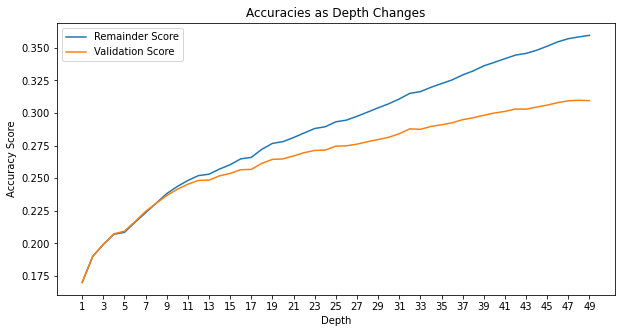

In [ ]:
# comparison plot
plt.figure(figsize=(10,5))
plt.plot('Depth', 'Remainder Score', data=scores)
plt.plot('Depth', 'Validation Score', data=scores)
plt.title('Accuracies as Depth Changes')
plt.xlabel('Depth')
plt.xticks(range(1,depth_range, 2))
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

In [ ]:
# running a decision tree model
DTmodel = DecisionTreeClassifier(max_depth=48)
DTmodel.fit(train_vec, y_train)

print(f"DT accuracy score on training set: {DTmodel.score(train_vec, y_train):0.3f}")
print(f"DT accuracy score on test set: {DTmodel.score(test_vec, y_test):0.3f}")

DT accuracy score on training set: 0.353
DT accuracy score on test set: 0.317


Decision trees performs very poorly on the datatset.

Seems like trains and test accuracies will keep on increasing with the increase in the depth parameter. The only thing which matters over here is the the optimal depth you want to choose.

May be you can use cross validation to check the optimal value
But let's focus on random forest model and draw the comparison.

---

---

### Random Forest model

Let's fit the vectorizer and classifier in a pipeline and set parameters for both tf-idf and random forest classifier to find the optimal value.

In [ ]:
# Randomforest pipeline setup
rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('rf', RandomForestClassifier())
])


# Fit
rf_pipe.fit(X_train['headline'], y_train)


# Setting up randomforest params
rf_params = {
 'tvec__max_features':[3000],
 'tvec__min_df':[2, 5, 10],
 'tvec__ngram_range': [(1, 2), (1, 3)],
 'tvec__stop_words': ['english'],
 'rf__max_depth': [800, 700],
 'rf__min_samples_split': [100]
}

Now we have define our pipe, let's fit it into the girdsearch.

In [ ]:
# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 5, verbose = 1, n_jobs = -1)


# Fitting Randomforest CV GS
fittedgrid = rf_gs.fit(X_train['headline'], y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
fittedgrid.best_params_

{'rf__max_depth': 1000,
 'rf__max_leaf_nodes': None,
 'rf__min_samples_split': 100,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [ ]:
# accuracy of the train set
rf_gs.score(X_train['headline'], y_train)

0.6989339146534476

In [ ]:
# accuracy on the test set
rf_gs.score(X_test['headline'], y_test)

0.5318808380515541

Our random forest model is slightly overfitting on the above parameters as accuracy of train set is a little higher.



Let's check the recall and precision score.

In [ ]:
# Get class predictions
y_pred = rf_gs.predict(X_test['headline'])

In [ ]:
# Precision 
from sklearn.metrics import precision_score

# precision_score(true labels, predicted labels)
precision_score(y_test, y_pred, average='macro')

0.5318808380515541

In [ ]:
# Recall
from sklearn.metrics import recall_score

# recall_score(true labels, predicted labels)
recall_score(y_test, y_pred, average='macro')

0.5318808380515541

Let's draw the confusion matrix for this model, but it is going to be huge as we have 23 classes to classify.

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

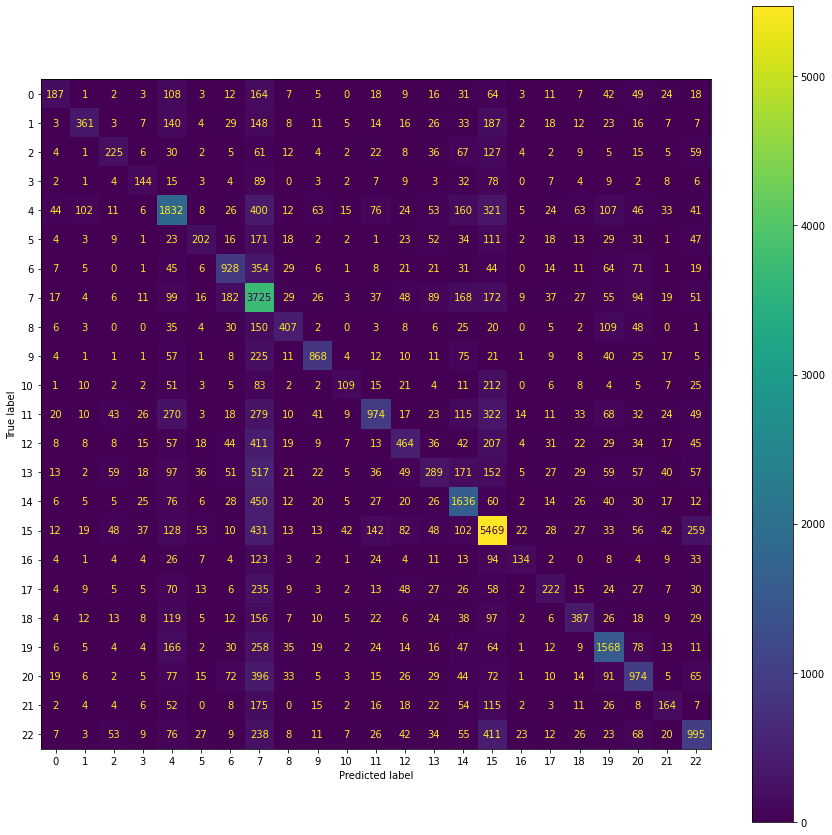

In [ ]:
# defining the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax)

This confusion matrix does not make any sense because we dont really know total negatives, false positives and false negatives. 

We have to calculate manually for each class.



So let's have a look at the classification report.

In [ ]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.24      0.32       784
           1       0.63      0.33      0.44      1080
           2       0.44      0.32      0.37       711
           3       0.42      0.33      0.37       432
           4       0.50      0.53      0.51      3472
           5       0.46      0.25      0.32       813
           6       0.60      0.55      0.58      1687
           7       0.40      0.76      0.53      4924
           8       0.58      0.47      0.52       864
           9       0.75      0.61      0.67      1415
          10       0.47      0.19      0.27       588
          11       0.63      0.40      0.49      2411
          12       0.47      0.30      0.37      1548
          13       0.32      0.16      0.21      1812
          14       0.54      0.64      0.59      2548
          15       0.65      0.77      0.70      7116
          16       0.56      0.26      0.36       515
          17       0.42    

Woow....

0 'ARTS & CULTURE'

1'COMEDY'

2'CRIME'

3 'EDUCATION' 

4 'ENTERTAINMENT'

5 'ENVIRONMENT' 

6 'FOOD & DRINK' 

7 'HEALTHY LIVING'

8 'HOME & LIVING'


9 'MARRIAGE & DIVORCE' 

10'MEDIA'

11 'MINORITIES' 

12'MONEY & BUSINESS' 

13 'OTHER NEWS'


14 'PARENTING'

15 'POLITICS'

16 'RELIGION' 


17'SCIENCE & TECH' 

18 'SPORTS'

19 'STYLE & BEAUTY'

20 'TRAVEL'

21 'WOMEN'

22 'WORLD NEWS'

__Interpretions from the above report__


1. Marriage and Divorce have the most precision among all categories (75%)
2. Healthy living and politics have almost same recall (75%)

---

__Summary:__

Random forest model is the basic model in this project. I look forward to deploy random forest and neural network model and check the performance of the model.


Also, to improve accuracy in this case, dimensionality reduction can be done and resampling (upsample/downsample) can be done as we have a imbalanced dataset. 

---

## Thank You!!